## Section 7.1.2 - Estimating multiple parameters (mixture modeling)

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
from scipy import stats, special
import seaborn as sea; sea.set_style('whitegrid')
import matplotlib.pyplot as plt; plt.ion()

Imagine we have a set of responses, and we think that some of them are from a Uniform distribution, and some are from a Normal distribution.

We can _create_ a new distribution by simply combining the two. We think some responses come from a Normal distribution,
$$ f(x\mid \mu,\sigma^2) = \frac{exp(-\frac{(x-\mu)^2}{2\sigma^2})}{\sqrt{2\pi\sigma^2}} $$
and others come from a Uniform distribution,
$$ f(x\mid a,b) = \frac{1}{b-a} $$


### Circular space.
Because we are using _circular_ space, we use the circular Normal (Von Mises) distribution, 

$$ f(x\mid \mu,k) = \frac{e^{k \cos(x-\mu)}}{2\pi I_0(k)} \qquad (I_0(k)\text{ is a fancy Bessel function}) $$

and our Uniform distribution will be $\mathcal{U}(-\pi,\pi)$

$$ f(x\mid -\pi,\pi) = \frac{1}{\pi-(-\pi)} = \frac{1}{2\pi}$$

### Combine

To avoid rewriting the whole Von Mises distribution, we can just refer to it with the symbol $\phi_{\mu,k}$.

**And here is where we enter one of our main parameters of interest, $g$.**

This parameter denotes _what proportion of responses come from the Uniform_. Since $g$ is a proportion, it's restricted between $0$ and $1$. If the contribution of the Uniform is parameter $g$, then the contribution of the only other option--the Von Mises--is the value $1-g$.

To combine the distributions into **one mixture model**, we just add the two together, with each contributing its appropriate proportion.

$$ f(x\mid k,\sigma) = (1-g)\phi_{\mu,k}(x) + g\frac{1}{2\pi} $$

The other parameter of interest is the $k$ parameter for the Von Mises distribution. This can be considered the standard deviation of the Von Mises, and we repeatedly use a `sd2kappa` function below, so that we can talk in terms of the more comfortable standard deviation, $\sigma$. So below, we search for $\sigma$, but the parameter in the distribution is $k$.

Now we have 2 unknown parameters, $g$ and $\sigma$. These are the parameters we want to _find_ with modeling, either through MLE or Bayesian estimation.

### Simulate the data

In [3]:
# choose true parameters first
tru_params = pd.DataFrame.from_dict({
    3: dict(g=.01, sigma=40),
    6: dict(g=.30, sigma=80)
},orient='index')

tru_params

,sigma,g
3,40,0.01
6,80,0.30


In [3]:
# use those parameters to simulate both conditions in one subject

def sd2kappa(sd):
    '''helper function for dealing with Von Mises shape parameter k
    input: standard deviation in degrees
    output: kappa in radians
    '''
    s = np.deg2rad(sd)
    r = np.exp(-s**2 / 2)
    if r < 0.53:
         k = 2*r + r**3 + (5*r**5)/6
    elif r < 0.85:
         k = -.4 + 1.39*r + .43/(1-r)
    else:
        k = 1/(r**3 - 4*r**2 + 3*r)
    return k


n_trials = 1000

data = pd.DataFrame(index=pd.MultiIndex.from_product(
    [[3,6], range(n_trials)], names=['setsize','trial']),
    columns=['error'], dtype=float)

# simulate responses
for ss, t in data.index:
    
    # extract true parameters
    g, sigma = tru_params.loc[ss,['g','sigma']]

    # g works probabilistically
    rand = np.random.uniform()
    if rand < g:
        # respond from Uniform
        error = np.random.uniform(-np.pi,np.pi)
    else:
        # respond from Von Mises
        k = sd2kappa(sigma)
        error = np.random.vonmises(mu=0,kappa=k)

    # convert to degrees for interpretability
    # (although going to convert back later)
    data.loc[(ss,t),'error'] = np.rad2deg(error)


data.head()

error
setsize trial           
3       0      13.478028
        1      10.484050
        2     -33.123371
        3      -1.338769
        4       0.902817

### Inspect simulated data

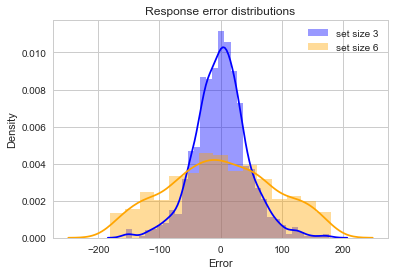

In [4]:
ax = sea.distplot(list(data.loc[3,'error'].values), color='blue', label='set size 3')
ax = sea.distplot(list(data.loc[6,'error'].values), color='orange', label='set size 6', ax=ax)
plt.title('Response error distributions')
plt.xlabel('Error')
plt.ylabel('Density')
plt.legend();

### Try to "recover" the parameters using mixture modeling.

#### Preliminary tools

In [4]:
def logmixturepdf(rad_data, g, sd):
    '''get likelihood of the data given this parameter set
    '''
    # maybe insert a check here that it is wrapped around 0 too, by checking for pos and neg values
    k = sd2kappa(sd)
    vm_contribution = (1-g) * stats.vonmises(loc=0,kappa=k).pdf(rad_data)
    unif_contribution = g * stats.uniform(-np.pi,2*np.pi).pdf(rad_data)
    ll = np.sum(np.log(vm_contribution + unif_contribution))
    return ll



def logprior(g,sd):
    '''priors are dependent on the parameters, so this gets new priors for each parameter set
    '''
    # jeffrey's prior for a proportion (g)
    jf_prop = g**-.5 * (1-g)**-.5
    
    # jeffrey's prior for precision
    k = sd2kappa(sd)
    z = np.exp( (np.log(special.ive(1,k))+k) - (np.log(special.ive(0,k))+k) )
    jf_prec = z * (k-z-k*z**2)
    
    # make log prior
    return np.log(jf_prec) + np.log(jf_prop)

#### Main function to implement Metropolis-Hastings MCMC

In [6]:
def getmixtmodel(errors,start_params):
    '''
    ARGS:
        errors        - 1D array of error data in radians (-pi,pi)
        start_params  - [g, sigma]
    RETURNS:
        posterior     - [n_samples,2] array, 1st col is g samples, 2nd col is sigma samples
    '''
    chain = np.zeros([5000,2])
    burnin = 500
    propsd = start_params*.5
    lower_bound = [0,4]
    upper_bound = [1,360]
    
    chain[0,:] = start_params
    for i in range(1,chain.shape[0]):
        curr = chain[i-1,:]
        
        # make new proposal by adding noise to the current proposal
        # and make sure it stays within our bounds
        doitagain = True
        while doitagain:
            prop1 = curr + np.random.normal(0,propsd)
            if np.any(prop1>upper_bound) or np.any(prop1<lower_bound):
                doitagain = True
            else:
                doitagain = False
        
        # get the likelihood of current and proposed values
        # **note this is where prior gets added
        lpropval = logmixturepdf(errors, prop1[0], prop1[1]) + logprior(prop1[0], prop1[1])
        lcurrval = logmixturepdf(errors, curr[0], curr[1]) + logprior(curr[0], curr[1])
        # get likelihood ratio
        llratio = np.exp(lpropval-lcurrval)
        
        # keep the sample on a probabilistic basis, dependent on the likelihood ratio
        if np.random.uniform() < llratio:
            chain[i,:] = prop1
        else:
            chain[i,:] = curr

    # get rid of the burnin
    posterior = chain[burnin:]

    return posterior

### Perform Metropolis-Hastings MCMC on our data to derive posteriors.
_(recreating figure 7.4)_

## SET SIZE 3 ##
FINAL PARAMS:
    g = 0.015
    sd = 41.458
TRUE PARAMS:
    g = 0.010
    sd = 40.000
## SET SIZE 6 ##
FINAL PARAMS:
    g = 0.215
    sd = 84.770
TRUE PARAMS:
    g = 0.300
    sd = 80.000


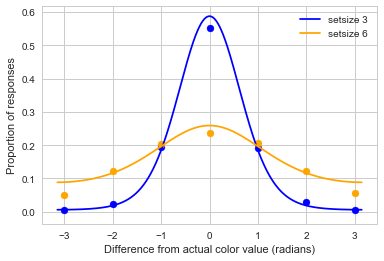

In [7]:
for setsize in [3,6]:

    # extract data and start parameters from simulated stuff
    errors = np.deg2rad(data.loc[setsize,'error'])
    start_params = tru_params.loc[setsize,['g','sigma']]

    # get the posterior from MCMC on the mixture model
    posterior = getmixtmodel(errors, start_params)


    # final parameters are the means of the accepted values
    final_params = np.mean(posterior, axis=0)
    g, sd = final_params

    print '## SET SIZE {:d} ##'.format(setsize)
    print 'FINAL PARAMS:'
    print '    g = {:.03f}'.format(g)
    print '    sd = {:.03f}'.format(sd)
    print 'TRUE PARAMS:'
    print '    g = {:.03f}'.format(start_params[0])
    print '    sd = {:.03f}'.format(start_params[1])

    if setsize == 3:
        color = 'blue'
    else:
        color = 'orange'

    # plot the distribution made from the final parameters estimates
    x = np.linspace(-np.pi,np.pi,1000)
    k = sd2kappa(sd)
    y = (1-g)*stats.vonmises(loc=0,kappa=k).pdf(x) + g*stats.uniform(-np.pi,2*np.pi).pdf(x)

    plt.plot(x,y, c=color, label='setsize {:d}'.format(setsize))


    # plot the actual data, binned into dots
    # bins = np.arange(np.floor(errors.min()),np.ceil(errors.max())+1)
    bins = np.arange(-3.5,4.5)
    hist, bins = np.histogram(errors, bins=bins, density=True)
    # width = np.diff(bins) #need this for barplots
    center = (bins[:-1] + bins[1:]) / 2
    plt.scatter(center,hist, c=color)


plt.ylabel('Proportion of responses')
plt.xlabel('Difference from actual color value (radians)')
plt.legend();

## Figure 7.5

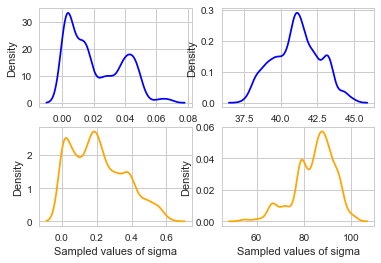

In [8]:
# redo the analysis, this time plotting the posterior distributions themselves, for each parameter

f, axes = plt.subplots(2,2)
axes.shape

colors = ['blue','orange']

for i, setsize in enumerate([3,6]):

    # extract data and start parameters from simulated stuff
    errors = np.deg2rad(data.loc[setsize,'error'])
    start_params = tru_params.loc[setsize,['g','sigma']]

    # get the posterior from MCMC on the mixture model
    posterior = getmixtmodel(errors, start_params)

    # extract posteriors for each distribution
    post_g = posterior[:,0]
    post_sigma = posterior[:,1]
    
    # plot
    sea.kdeplot(post_g, color=colors[i], ax=axes[i,0])
    sea.kdeplot(post_sigma, color=colors[i], ax=axes[i,1])


for r, row in enumerate(axes):
    for ax in row:
        ax.set_ylabel('Density')
        xlabel = 'Sampled values of g' if r==0 else 'Sampled values of sigma'
        ax.set_xlabel(xlabel)